In [1]:
import sys
import os
import random
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import numpy as np
from math import *
from time import time
import random
from astropy.io import ascii
from astropy.table import Table, Column 
from scipy  import interpolate

In [2]:
table = np.genfromtxt('M_L_curve_v2.csv' , delimiter=',', filling_values=0, names=True, dtype=None)
Lumin_in   = table['log10_L']
Mass_out   = table['log10_M']
MtoL_mod = interpolate.interp1d(Lumin_in, Mass_out)

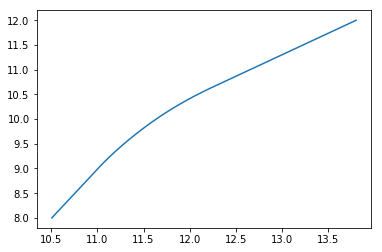

In [3]:
plt.plot(Mass_out, Lumin_in)

In [4]:
# Returns mass in solar unit, given the absolute K-band luminosity
def M2L_paper(L_k):
  
  global MtoL_mod

  if L_k==0:
    return 0
  
  L = L_k / 1.E10
  
  if L <= 0.0927:
    return 32.0*(L**-0.5)
  elif L > 0.0927 and L < 4.423:
    return 10**MtoL_mod(np.log10(L_k))/L_k
  elif L >= 4.423:
    return 32*(L**0.15)

  

Text(4e+11,70,'$L^{0.15}$')

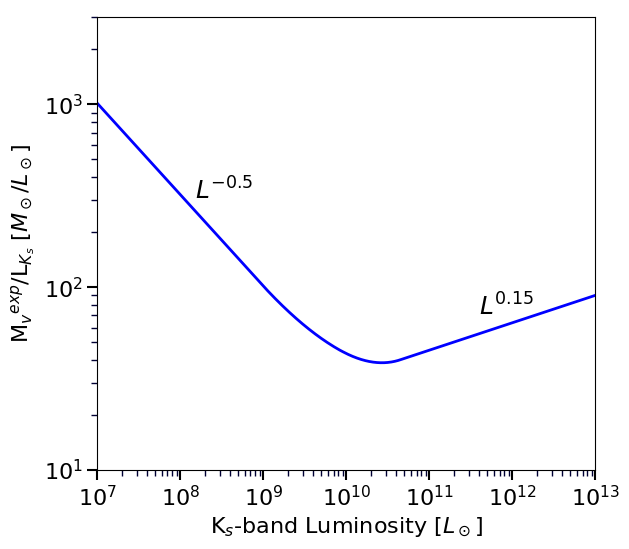

In [5]:
from matplotlib.pyplot import figure

figure(figsize=(45/7., 6), dpi=100)

L = np.logspace(7, 13, 2000)
MtoL = np.asarray([M2L_paper(l) for l in L])


plt.plot(L, MtoL, '-', color='blue', linewidth=2) 

plt.xscale('log')
plt.yscale('log')
plt.xlim(1.E7,1.E13)
plt.ylim(1.E1,3.E3)

plt.ylabel('M'+r'$_v$'+r'$^{exp}$'+'/L'+r'$_{K_s}$'+' ['+r'$M_\odot/L_\odot$'+']', fontsize=16)
plt.xlabel('K'+r'$_s$'+'-band Luminosity ['+r'$L_\odot$'+']', fontsize=16)

#plt.minorticks_on()
plt.tick_params(which='major', length=7, width=1.5)
plt.tick_params(which='minor', length=4, color='#000033', width=1.0)     

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.annotate(r'$L^{-0.5}$', (1.5E8, 3.E2), rotation=0, color='black', size=18)
plt.annotate(r'$L^{0.15}$', (4.E11, 7.E1), rotation=0, color='black', size=18)

In [6]:
myTable = Table()
myTable.add_column(Column(data=np.log10(L), name='log10(L_k)', format='%0.5f'))
myTable.add_column(Column(data=MtoL, name='M/L', format='%0.5f'))
myTable.write('MtoL_curve_v2.csv', format='ascii.fixed_width',delimiter=',', bookend=False)

In [7]:
# Returns mass in solar unit, given the absolute K-band luminosity
def Mass2(L_k):

  L = L_k / 1.E10
  

  if L <1:
    MtoL = 32.0*(L**-0.60)
  elif L >= 1:
    MtoL = 32*(L**0.15)
  

  
  
  Mass_out = L_k * MtoL
  
  return Mass_out



# Returns mass in solar unit, given the absolute K-band luminosity
def Mass_brent(L_k):
  
  if L_k==0:
    return 0
  
  L = L_k / 1.E10
  
  # ORIGINAL
  if L <= 1:
    MtoL = 32.0*(L**-0.5)     # Original
  else:
    MtoL = 32*(L**0.15)
  
  Mass_out = L_k * MtoL
  
  return Mass_out


#################################################################

def stat(array, mi, mf):
    
    #array = np.asarray(array)
    #N = len(array)
    
    #f1 = np.zeros(N)
    #f2 = np.zeros(N)
    
    #f1[np.where(array>=mi)] = 1
    #f2[np.where(array<mf)] = 1
    #f = f1 + f2
    
    #N = len(f[np.where(f==2)])
    
    N=0
    for a in array:
        if a>=mi and a<mf:
            N+=1
    
    

    return N
#################################################################

In [8]:
def plot_shell(Mv_lum, dist, M_bins, d_min=None, d_max=None, color=None, plot=False):
    

    
    if d_min!=None:
        indices = np.where(dist>d_min)
        Mv_lum_b = Mv_lum[indices]
        dist_b   = dist[indices]  
    else:
        dist_b = dist
        Mv_lum_b = Mv_lum
        
    
    if d_max!=None:
        indices = np.where(dist_b<d_max)
        Mv_lum_b = Mv_lum_b[indices]
        dist_b   = dist_b[indices]      
    
    if d_min==None and d_max==None:
        Mv_lum_b = Mv_lum
        dist_b   = dist
    
    if color==None:
        color='black'
    
    M = M_bins

    n_lst = []
    m_lst = []
    
    for i in range(len(M)-1):
        
        n_lst.append(stat(Mv_lum_b, M[i], M[i+1]))
        m_lst.append(sqrt(M[i]*M[i+1]))
    
    m_lst = np.asarray(m_lst)
    n_lst = np.asarray(n_lst)
    #plt.ploterr(m_lst,1.*n_lst, '.', color=color)
    
    if plot: 
      plt.errorbar(m_lst,1.*n_lst, yerr=np.sqrt(n_lst), fmt='.', color=color)    
    
    return m_lst, n_lst, np.sqrt(n_lst)
#################################################################
def xi2(M_func, m0,n00, n00_err):
    
    xi2_min = 1.E12
    alf = 0
    for alfa in np.arange(1,100,0.1):
        xi2 = 0
        for i in range(len(m0)):
           if n00[i]>0 and m0[i] > 4.5E12 and m0[i] <1.E14:
               x = log10(alfa*n00[i])
               x_model = log10(M_func(m0[i]))
               y_err = n00_err[i]/n00[i]/0.4342944
               xi2 += ((x-x_model)/(y_err))**2
        if xi2<xi2_min:
            alf = alfa
            xi2_min = xi2
        #print  alfa, xi2
    return alf    # alf = 16. for min xi2


def xi2_tail(M_func, m0,n00, n00_err):
    
    xi2 = 0
    for i in range(len(m0)):
       if  n00[i]>0 and m0[i] < 1.0E14 and m0[i] >= 1.0E11:
          #if n00_err[i]<1: n00_err[i]=1 
          x = log10(n00[i])
          x_model = log10(M_func(m0[i]))
          y_err = n00_err[i]/n00[i]/0.4342944
          #if y_err<1: y_err = 1
          xi2 += ((x-x_model)/(y_err))**2

    return xi2
##################################################################
def calcMassFunc(Mv_lum, dist, plot=False):
    
    M_bins = np.logspace(10,14,20)
    M_bins = np.append(M_bins, [1.E15])
    Nbins = len(M_bins)

    
    
    m0,n0, nerr0 = plot_shell(Mv_lum, dist, M_bins, d_min=20, d_max=40)
    for i in [0,1,2]: n0[i]=0;nerr0[i]=0
    #if plot: plt.errorbar(m0,n0,yerr=nerr0, fmt='.', color='red')
    
    m1,n1, nerr1 = plot_shell(Mv_lum, dist, M_bins, d_max=6)
    #if plot: plt.errorbar(m1,n1,yerr=nerr1, fmt='.', color='black')
    
    m2,n2, nerr2 = plot_shell(Mv_lum, dist, M_bins, d_min=6, d_max=10)
    for i in [0,1]: n2[i]=0;nerr2[i]=0
    #if plot: plt.errorbar(m2,n2,yerr=nerr2, fmt='.', color='blue')
    
    m3,n3, nerr3 = plot_shell(Mv_lum, dist, M_bins, d_min=10, d_max=20)
    for i in [0,1]: n3[i]=0;nerr3[i]=0
    #if plot: plt.errorbar(m3,n3,yerr=nerr3, fmt='.', color='green')
     
    
    N1=0; N0=0
    for i in range(len(n1)):
        if n1[i]!=0 and n0[i]!=0:
            N1+=n1[i]
            N0+=n0[i]
    n11     = np.zeros(len(n1))
    n11_err = np.zeros(len(n1))
    for i in range(len(n1)):
        n11[i] = n1[i]*N0/N1
        n11_err[i] = nerr1[i]*N0/N1


 
    N2=0; N0=0
    for i in range(len(n2)):
        if n2[i]!=0 and n0[i]!=0:
            N2+=n2[i]
            N0+=n0[i]
    n22     = np.zeros(len(n2))
    n22_err = np.zeros(len(n2))
    for i in range(len(n2)):
        n22[i] = n2[i]*N0/N2
        n22_err[i] = nerr2[i]*N0/N2

 
 
    N3=0; N0=0
    for i in range(len(n3)):
        if n3[i]!=0 and n0[i]!=0:
            N3+=n3[i]
            N0+=n0[i]
    n33     = np.zeros(len(n3))
    n33_err = np.zeros(len(n3))
    for i in range(len(n3)):
        n33[i] = n3[i]*N0/N3
        n33_err[i] = nerr3[i]*N0/N3

    
    
    n00     = np.zeros(len(n0))
    n00_err = np.zeros(len(n0))
    for i in range(len(n0)):
        sum = 0
        semerr = 0
        if n33[i]!=0:
            sum += n33[i]/n33_err[i]
            semerr += 1./n33_err[i]
        if n22[i]!=0:
            sum += n22[i]/n22_err[i]
            semerr += 1./n22_err[i]
        if n11[i]!=0:
            sum += n11[i]/n11_err[i]
            semerr += 1./n11_err[i]
        if n0[i]!=0:
            sum += n0[i]/nerr0[i]
            semerr += 1./nerr0[i]
        if semerr!=0: 
            n00[i] = sum/semerr
            n00_err[i] = sqrt(2.)/semerr
        else:
            n00[i] = 0    
    
    #plt.errorbar(m0,n00*4,yerr=n00_err*4 ,fmt='.', color='magenta')  
    
    alf = xi2(M_func, m0,n00, n00_err)
    #alf = 16.0
    print "results: ", alf
    if plot: 
        #m0 = m0[3:]
        #n00 = n00[3:]
        #n00_err = n00_err[3:]
        plt.errorbar(m0,n00*alf,yerr=n00_err*alf , fmt='.', color='red')
        line1, = plt.plot(m0,n00*alf, '.', color='red', label='KT2017 M/L')
        plt.legend(handles=[line1], loc=1)
        
        
        
        myTable = Table()
        myTable.add_column(Column(data=np.log10(m0), name='logM', format='%0.3f'))
        myTable.add_column(Column(data=np.log10(n00*alf), name='logN', format='%0.3f'))
        myTable.add_column(Column(data=np.log10(n00_err*alf), name='logNerr', format='%0.3f'))
        myTable.write('Mass_function_red.csv', format='ascii.fixed_width',delimiter=',', bookend=False)
    
    return m0, n00*alf, n00_err*alf
      
################################################################
def M2L_init():
    
      L = 1E13
      L_lst = []
      M2L_lst = []
      while L>= 9.E6:
          M = Mass_brent(L)
          M2L_lst.append(M/L)
          L_lst.append(L)
          L = L/1.77827941
      
      return L_lst, M2L_lst
#################################################################
def M2L_mutate(L_lst, M2L_lst):
      
      M2L_lst_new = []
      j = 0
      while(L_lst[j]>=1.E11): j+=1
      
      p = random.randint(j,len(M2L_lst))
      for i in range(len(M2L_lst)):
          alfa = 1.
          if i==p: alfa = random.normalvariate(0, 5)
          
          if alfa>=0: M2L_lst_new.append(M2L_lst[i]*alfa)
          if alfa<0: M2L_lst_new.append(M2L_lst[i]/abs(alfa))
      
      return M2L_lst_new  
  
  
#################################################################
def L_015(L_k):
      L = L_k / 1.E10
      return 32*(L**0.15)
  
def MtoLrand():
      
      
      slopes = np.arange(0.15,-1.01,-0.01)
      L = 1E13
      L_lst = []
      M2L_lst = []
      while L>= 9.E6:
          
          if L>= 9.E10:
              M2L_ = L_015(L)
          else:
              p = random.randint(0,116)
              alfa = slopes[p]
              M2L_ = (M2L_/L_**alfa)*L**alfa

          M2L_lst.append(M2L_)
          L_lst.append(L)
          L_ = L
          L = L/sqrt(10)
      
      myM2L = interpolate.interp1d(L_lst, M2L_lst)
      
      return  myM2L




def L_exp(M, alfa, beta, gama):
    
    M12 = M/1.E12
    
    log10L = log10(alfa) + 10. + beta*log10(M12) + (gama/M12)*log10(exp(1.))
    
    return 10**log10L


def M_exp_f(alfa, beta, gama):
    
    Lbin = np.logspace(7,13,2000)
    Mbin = np.logspace(10,40,2000) 
    
    for i in range(len(Mbin)): Lbin[i] = L_exp(Mbin[i], alfa, beta, gama)
    
    M_f = interpolate.interp1d(np.log10(Lbin), np.log10(Mbin))
    
    return M_f

#################################################################
def median(target, array, mi, mf):
    
    array = np.asarray(array)
    N = len(array)
    
    f1 = np.zeros(N)
    f2 = np.zeros(N)
    
    f1[np.where(array>=mi)] = 1
    f2[np.where(array<mf)] = 1
    f = f1 + f2
    
    ML = target[np.where(f==2)]
    media = np.median(ML)
    stdev = np.std(ML)
    
    N = len(ML)
    f1 = np.zeros(N)
    f2 = np.zeros(N)
    f1[np.where(ML<=media+2*stdev)] = 1
    f2[np.where(ML>=media-2*stdev)] = 1
    f = f1 + f2    
    ML = ML[np.where(f==2)]
    media = np.median(ML)
    stdev = np.std(ML)        

    N = len(ML)
    f1 = np.zeros(N)
    f2 = np.zeros(N)
    f1[np.where(ML<=media+3*stdev)] = 1
    f2[np.where(ML>=media-3*stdev)] = 1
    f = f1 + f2    
    ML = ML[np.where(f==2)]
    media = np.median(ML)
    stdev = np.std(ML)   

    

    return media, stdev
#################################################################
def Mock_ML():
    
  table = np.genfromtxt('halo.0.100.v01.group' , delimiter='|', filling_values=0, names=True, dtype=None)
  flag    = table['flag']
  grpID   = table['grpID']
  logK    = table['logK']
  Mv_lum  = table['Mv_lum']
  dist    = table['dist']
  Vls     = table['Vls']
  N = len(flag)
    
  table = np.genfromtxt('halos_simple_mock-14.0.csv' , delimiter=',', filling_values=0, names=True, dtype=None)
  grpID2   =  table['grpID']
  HaloMass =  table['HaloMass']
  
  M_halo =  np.zeros(N)
  L_halo =  np.zeros(N)
  for i in range(N):
        
        if flag[i]==2:
            grpID[i] = grpID[i+1]
        
        if flag[i]!=1:  # !=1
            index=np.where(grpID2==grpID[i])[0]
            
            #print i, index, grpID2[index], grpID[i]
            M_halo[i]=HaloMass[index]
            #M_halo[i]=Mv_lum[i]
            L_halo[i]=10**logK[i]
          
  #ax.plot(L_halo,M_halo/L_halo, '.', markersize=1, color='black', alpha=0.1)
  
  
  M2L_halo = M_halo/L_halo
  

  alfa =  2
  M1   =  0.5E7
  
  m0 = M1
    
  x = []
  y = []
  y_err = []
    
  while m0<1.E14:
        
        m1 = m0*alfa 
        med, stdev = median(M2L_halo, L_halo, m0, m1)
        y.append(med)
        y_err.append(stdev)
        x.append(sqrt(m0*m1))
        m0 = m1
        if m0>1.E11: alfa=2.5
  
  x = np.asarray(x)
  y = np.asarray(y)
  y_err = np.asarray(y_err)


  
  
  M2L_f = interpolate.interp1d(np.log10(x), np.log10(y*3.2))
    
  return M2L_f  

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


results:  21.80000000000002
130.01288951242412


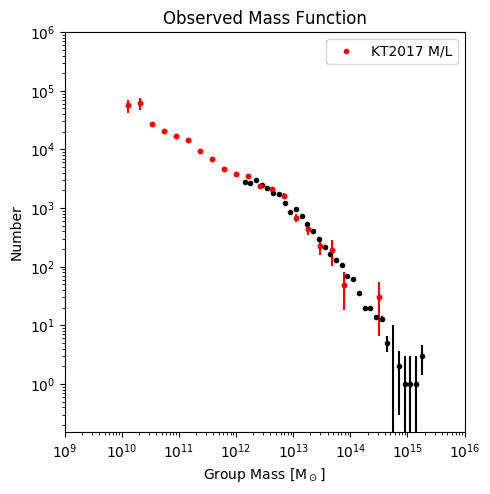

In [9]:

##################################################
table = np.genfromtxt('MW_17ST_H100.csv' , delimiter=',', filling_values=0, names=True, dtype=None)
logMass = table['logMass']
nl20 = table['nl20']


##################################################
fig = plt.figure(figsize=(5,5), dpi=100)
#ax = fig.add_subplot()
ax = fig.add_axes([0.15, 0.13, 0.80,  0.80])


table = np.genfromtxt('groupmassfunction3_10a.csv' , delimiter=',', filling_values=0, names=True, dtype=None)
logM = table['logM']
logN = table['logN']
logNerr = table['Nerr']


table = np.genfromtxt('groupmassfunction3_6.5b.csv' , delimiter=',', filling_values=0, names=True, dtype=None)
logMb = table['logM']
logNb = table['logN']
logNerrb = table['Nerr']   

plt.errorbar(10**logM, 10**logN, yerr=10**logNerr , fmt='.', color='black')
plt.errorbar(10**logMb, 5*10**logNb, yerr=5*10**logNerrb ,  fmt='.', color='black')


M_black = np.concatenate((logM, logMb))
N_black = np.concatenate((logN, logNb+np.log10(5.)))
Ne_black = np.concatenate((logNerr, logNerrb+np.log10(5.)))

myTable = Table()
myTable.add_column(Column(data=M_black, name='logM', format='%0.3f'))
myTable.add_column(Column(data=N_black, name='logN', format='%0.3f'))
myTable.add_column(Column(data=Ne_black, name='logNerr', format='%0.3f'))
myTable.write('Mass_function_black.csv', format='ascii.fixed_width',delimiter=',', bookend=False)

##plt.plot(10**logMass, 10**nl20, 'r--')
#plt.plot(10**logMass, 10**(nl20+0.662), '--', color='black')

M_func = interpolate.interp1d(10**logMass, 10**(nl20+0.662))


##################################################
table = np.genfromtxt('all.iter.2.v44.group' , delimiter='|', filling_values=0, names=True, dtype=None)
flag   =  table['flag']
Mv_lum =  table['Mv_lum']
dcf2 =  table['dcf2']
mDist =  table['mDist']

Vls =  table['Vls']
logK = table['logK']
######Mv_lum = table['Mv_dyn']

N = len(flag)
dist = np.zeros(N)

for i in range(N):
    if flag[i] ==2:
        dist[i] = mDist[i]
    else:
        dist[i] = dcf2[i]


for i in range(N):
   if dist[i]==0:
       dist[i] = Vls[i]/75.


indices = np.where(flag!=1)
Mv_lum = Mv_lum[indices]
logK = logK[indices]
dist   = dist[indices] 

indices = np.where(logK>7)
Mv_lum = Mv_lum[indices]
logK = logK[indices]
dist   = dist[indices] 

N = len(logK)

#for i in range(N):
   #Mv_lum[i] = Mass_brent(10**logK[i])



#myM2L = MtoLrand()

#######################################
def myM2L_(L_k, alfa):


   L = L_k / 1.E10
   if L>=1: 
       return 32.*(L**0.15)
   else:
       return 32.*(L**alfa)

def myM2L__(alfa):

   L_lst = [1.E13, 4.423E10, 9E8, 1.E7]
   M2L_lst = [myM2L_(1.E13, alfa), myM2L_(4.423E10, alfa), myM2L_(9E8, alfa), myM2L_(1.E7, alfa)]

   L_lst = np.asarray(L_lst)
   M2L_lst = np.asarray(M2L_lst)

   myM2L = interpolate.interp1d(np.log10(L_lst), np.log10(M2L_lst))

   return myM2L  


#######################################


#L_lst, M2L_lst = M2L_init()
#M2L_lst = [90.1883, 82.7275, 75.8840, 69.6065, 63.8484, 58.5666, 53.7217, 49.2776, 45.2012,  1.2297, 67.9711, 38.5747, 65.4234, 47.1529, 56.9049, 72.0329,  74.9229, 143.3098, 376.7528, 533.8714, 3434.2641, 1464.8879, 11501.0373, 6740.7212, 9292.1310]
#myM2L = interpolate.interp1d(L_lst, M2L_lst)


### paper KT2017
#f = myM2L__(-0.5)   ####   -0.9393
#for i in range(N): Mv_lum[i] = (10**f(logK[i]))*(10**logK[i])
for i in range(N): Mv_lum[i] = (M2L_paper(10**logK[i]))*(10**logK[i])


###alfa = 3.7043   
###beta = 0.8827   
###gama = -0.4347 


#### Best Fit
#alfa = 4.06 
#beta = 0.82   
#gama = -0.42 

#M_f = M_exp_f(alfa, beta, gama)
#for i in range(N): Mv_lum[i] = 10**M_f(logK[i])



#####  Mock M/L
#M2L_f = Mock_ML()
#for i in range(N): Mv_lum[i] = (10**M2L_f(logK[i]))*(10**logK[i])



m0,n00, n00_err = calcMassFunc(Mv_lum, dist, plot=True)
chi2 =  xi2_tail(M_func, m0, n00, n00_err) 

print chi2



## additional Y-axis (on the right)
#y_ax = ax.twinx()
#y_ax.set_ylim(0.15,1.E6)
#y_ax.set_yscale('log')
#y_ax.set_yticklabels([])
#y_ax.minorticks_on()
#y_ax.tick_params(which='major', length=5, width=1.5, direction='in')
#y_ax.tick_params(which='minor', length=2, color='#000033', width=1., direction='in')

## additional X-axis (on the right)
#x_ax = ax.twiny()
#x_ax.set_xlim(1.E9,1.E16)
#x_ax.set_xscale('log')
#x_ax.set_xticklabels([])
#x_ax.minorticks_on()
#x_ax.tick_params(which='major', length=5, width=1.5, direction='in')
#x_ax.tick_params(which='minor', length=2, color='#000033', width=1., direction='in')      



################################################## PLOT

plt.title('Observed Mass Function')
plt.xlabel('Group Mass [M'+r'$_\odot$'+']')
plt.ylim(0.15,1.E6)
plt.xlim(1.E9,1.E16)
plt.ylabel('Number')
plt.xscale('log')
plt.yscale('log')
plt.show()
##################################################



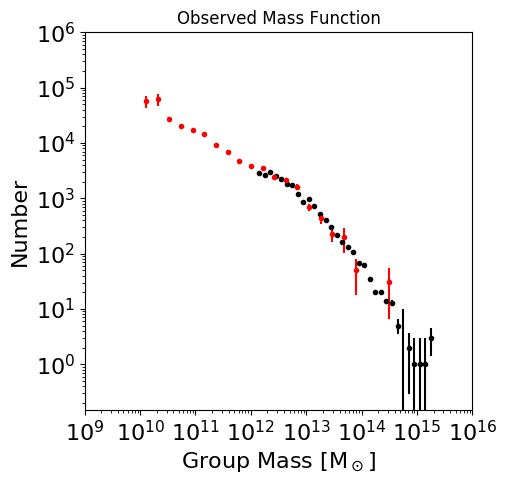

In [36]:
import pandas as pd


from matplotlib.pyplot import figure

figure(figsize=(5,5), dpi=100)

df = pd.read_csv('Mass_function_black.csv')
df.columns = [c.strip() for c in df.columns]
df = df.astype(float)
plt.errorbar(10**df.logM.values, 10**df.logN.values, yerr=10**df.logNerr.values,  fmt='.', color='black') 

df = pd.read_csv('Mass_function_red.csv')
df.columns = [c.strip() for c in df.columns]
df = df.astype(float)
plt.errorbar(10**df.logM.values, 10**df.logN.values, yerr=10**df.logNerr.values,  fmt='.', color='red') 

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Observed Mass Function')
plt.xlabel('Group Mass [M'+r'$_\odot$'+']', fontsize=16)
plt.ylim(0.15,1.E6)
plt.xlim(1.E9,1.E16)
plt.ylabel('Number', fontsize=16)
plt.xscale('log')
plt.yscale('log')

In [29]:
df = pd.read_csv('Mass_function_black.csv')
df.columns = [c.strip() for c in df.columns]
df = df.astype(float)

df = df.dropna()

df = df.sort_values(by=['logM'])

df.head(100)

,logM,logN,logNerr
38,12.15,3.448,0.717
39,12.25,3.422,0.718
40,12.35,3.471,0.717
41,12.45,3.400,0.718
42,12.55,3.343,0.719
43,12.65,3.262,0.721
44,12.75,3.232,0.722
45,12.85,3.086,0.726
46,12.95,2.935,0.731
47,13.05,2.980,0.729


In [34]:
myTable = Table()
myTable.add_column(Column(data=df.logM.values, name='logM', format='%0.3f'))
myTable.add_column(Column(data=df.logN.values, name='logN', format='%0.3f'))
myTable.add_column(Column(data=df.logNerr.values, name='logNerr', format='%0.3f'))
myTable.write('Mass_function_black.csv', format='ascii.fixed_width',delimiter=',', bookend=False)